In [1]:
# This code is adapted from:
# "A Tutorial on Quantum Dynamics Simulations on Quantum Computers. Part I: Closed Systems"
# by Brandon Allen et al., Yale University, 2024.
# https://cqdmqd.yale.edu/sites/default/files/2024-04/quantum_dynamics_tutorials_PartI_0.pdf
#B. Allen, D. G. A. Cabral, N. P. Vu, C. Cianci, X. Dan, and V. S. Batista, "A Tutorial on Quantum Dynamics Simulations on Quantum Computers. Part I: Closed Systems," Yale University, Apr. 2024. [Online]. Available: https://cqdmqd.yale.edu/sites/default/files/2024-04/quantum_dynamics_tutorials_PartI_0.pdf.

#additionally, code was adapted from:
# “Simulate Quantum Particles with Python and Qiskit - Python in Plain English” by Lohit Potnuru
#Lohit Potnuru, “Simulate Quantum Particles with Python and Qiskit - Python in Plain English,” Medium, Jan. 10, 2022. https://python.plainenglish.io/simulation-of-quantum-particles-with-python-and-qiskit-cfa656bb8773.

#finally, ChatGPT helped troubleshoot code

In [8]:
import numpy as np
import scipy.linalg as LA
from matplotlib import pyplot as plt #importing data functions for running simulations and displaying them

from qiskit import *
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.quantum_info.operators import Operator #import important Qiskit functions/modules and simulators


from qiskit.visualization import plot_histogram
import pylatexenc
from qiskit_ibm_runtime import QiskitRuntimeService #import qiskit plotting and real backend functions

import matplotlib.animation as animation
from matplotlib import rc

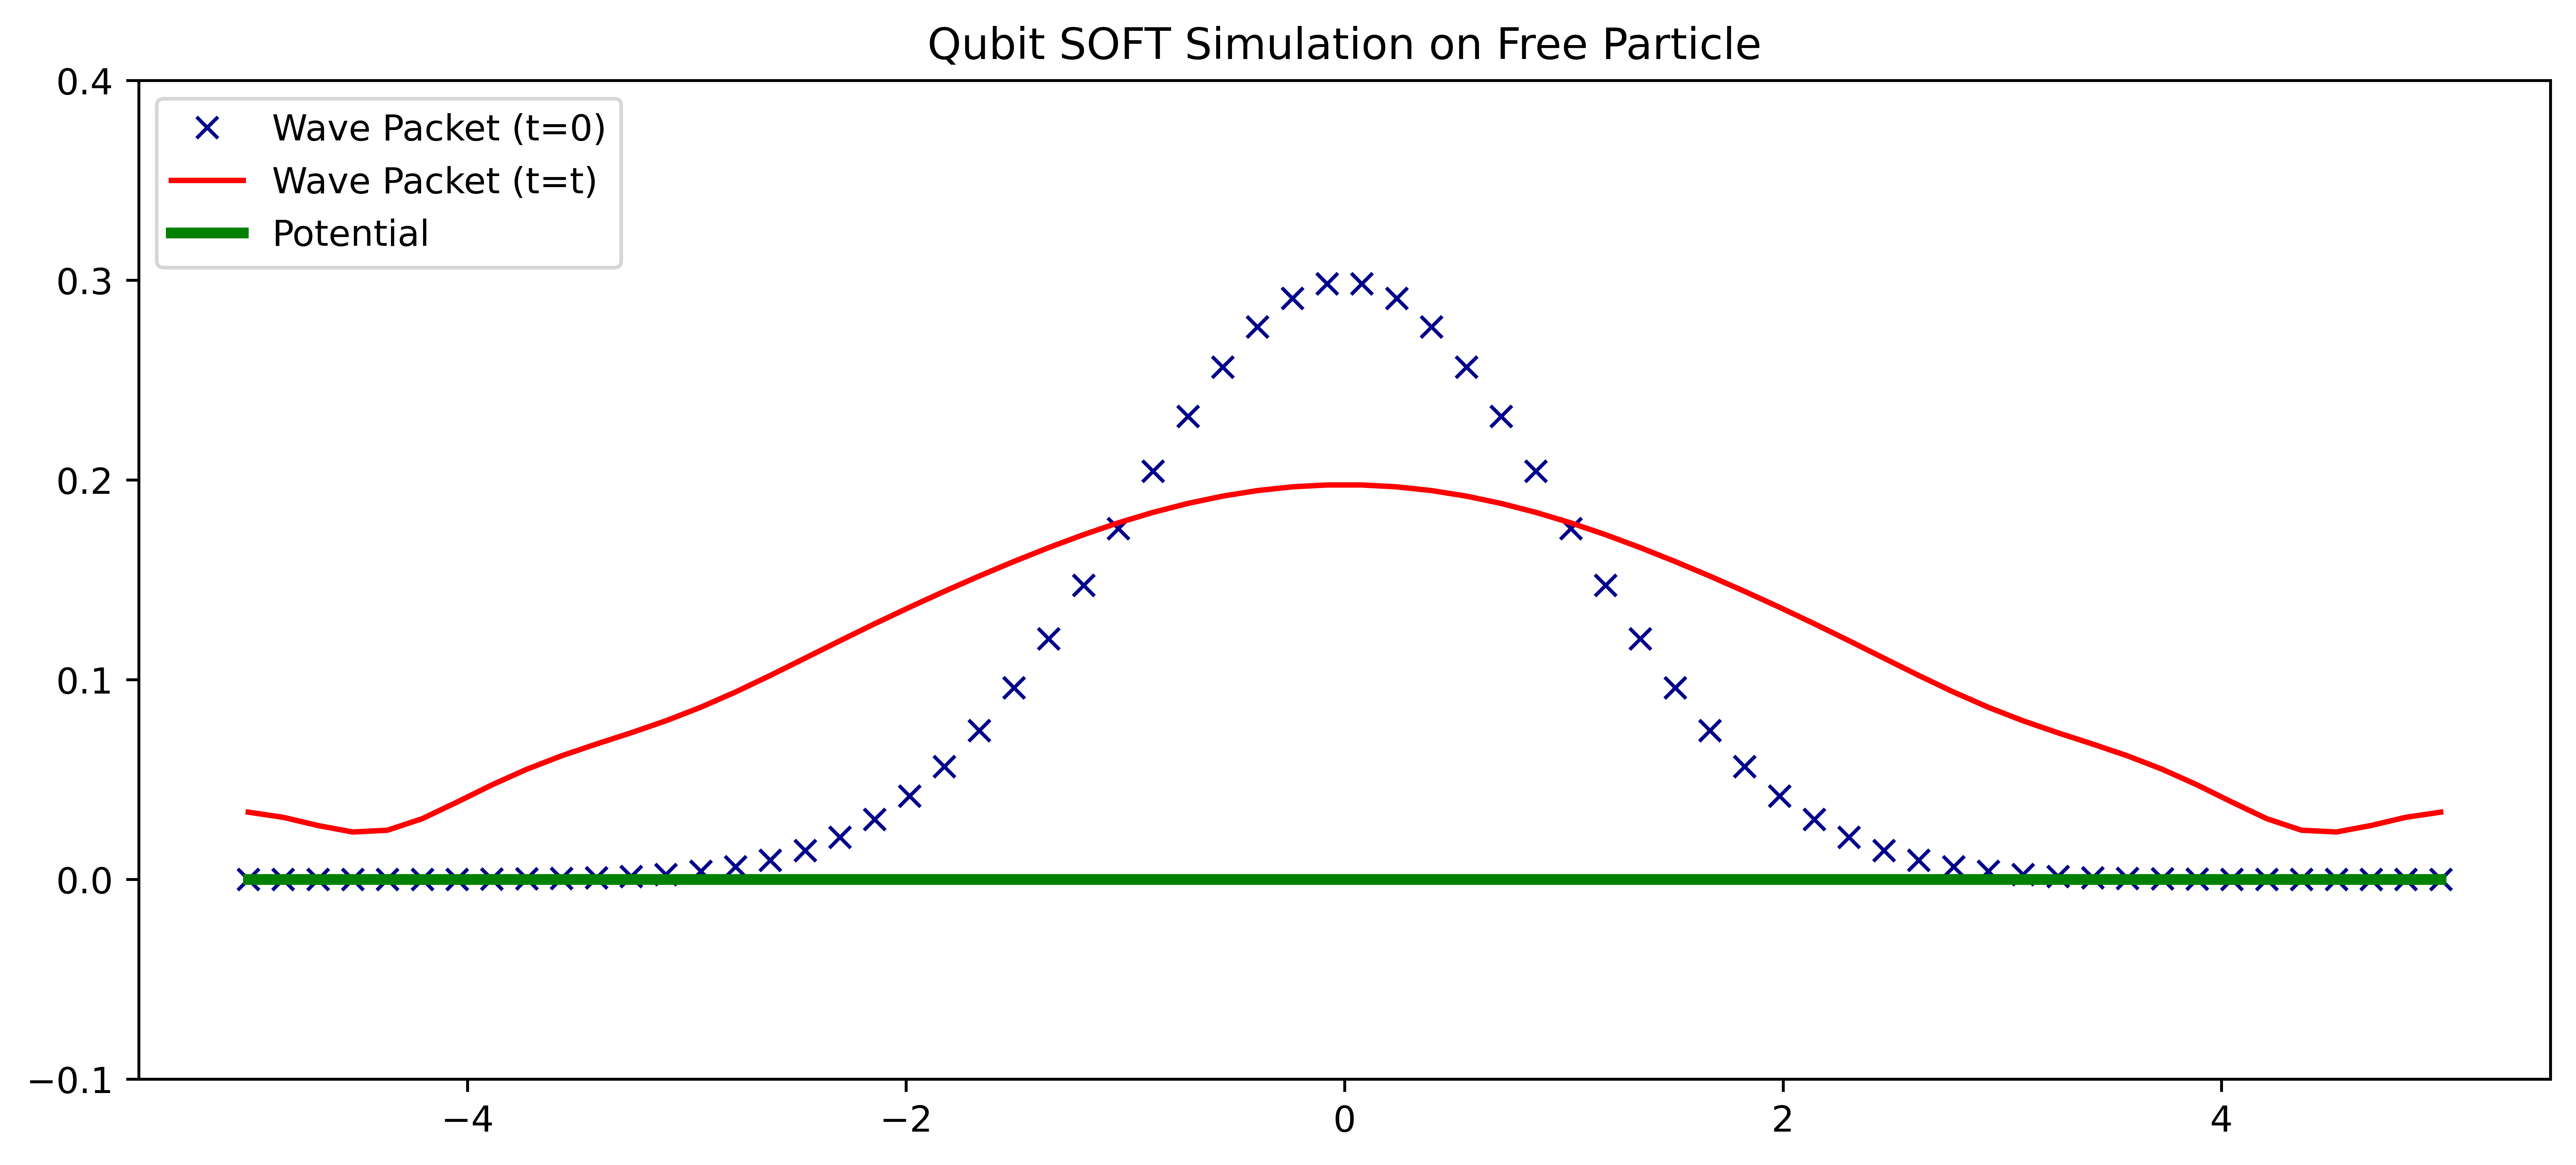

In [3]:
# https://cqdmqd.yale.edu/sites/default/files/2024-04/quantum_dynamics_tutorials_PartI_0.pdf

d = 6  # number of qubits
mass = 1  # mass of the particle
xMin = -5
xMax = 5
x = np.linspace(xMin, xMax, num=2**d)  # bounds of packet/simulation

V = 0 * x  # potential well function V=0 everywhere

# Gaussian wavepacket on a grid
mu = 0  # starting position
alpha = 1
psi = (alpha / np.pi) ** (0.25) * np.exp(-alpha * (x - mu) ** 2 * 0.5)  # state preparation
psi /= np.sqrt(np.sum(np.abs(psi) ** 2))  # normalized state

# PE and KE operators
dx = (xMax - xMin) / (2**d - 1)
dp = 2 * np.pi / (xMax - xMin)
N = 2**d  # number of total quantum states
p = np.zeros(N, dtype=float)
for i in range(N):
    p[i] = dp * (i - N / 2)
p = np.fft.fftshift(p)

dt = 0.01  # small time increment per iteration
iterations = 0  # number of total iterations. iterations * dt is total time evolution

# Create the potential and kinetic propagators
V_prop_half = np.diag(np.exp(-1j * V * dt / 2))  # half potential energy propagator
KE_prop = np.diag(np.exp(-1j * p**2 / 2 / mass * dt))  # kinetic energy propagator

# Initialize Quantum Circuit
nqubits = d
q_reg = QuantumRegister(nqubits)
c_reg = ClassicalRegister(nqubits)
qc = QuantumCircuit(q_reg)

qc.initialize(psi, q_reg[:])

# Time evolution loop
for k in range(iterations):
    # Apply half-step of the potential propagator
    bound_op = Operator(V_prop_half)
    qc.append(bound_op, q_reg)

    # Apply the Quantum Fourier Transform (QFT) to switch to momentum basis
    qc.append(QFT(d, do_swaps=True, inverse=True), q_reg)

    # Apply the full-step of the kinetic energy propagator
    bound_op = Operator(KE_prop)
    qc.append(bound_op, q_reg)

    # Apply inverse QFT to return to the position basis
    qc.append(QFT(d, do_swaps=True, inverse=False), q_reg)

    # Apply another half-step of the potential propagator
    bound_op = Operator(V_prop_half)
    qc.append(bound_op, q_reg)

# Save statevector to be recorded later
qc.save_statevector()

# Create the AerSimulator, specifying the statevector method
simulator = AerSimulator(method='statevector')

# Transpile the circuit for the AerSimulator
compiled_circuit = transpile(qc, simulator)

# Run the simulation
result = simulator.run(compiled_circuit).result()

# Get the statevector from the result
stateVectorResult = result.get_statevector()

# Visualizing result
plt.figure(figsize=[12, 5], dpi = 800)

plt.plot(x, abs(psi), 'x', label='Wave Packet (t=0)', color='darkblue')  # plotting original wavepacket
plt.plot(x, np.abs(stateVectorResult), label='Wave Packet (t=t)', color='red')  # plotting resulting wave packet
plt.plot(x, V, linewidth=3, label='Potential', color='green')  # plotting potential well

plt.title('Qubit SOFT Simulation on Free Particle')
plt.legend(loc='upper left')
plt.ylim(-0.1, 0.40)
plt.show()


In [4]:
# https://cqdmqd.yale.edu/sites/default/files/2024-04/quantum_dynamics_tutorials_PartI_0.pdf

d = 6  # number of qubits
mass = 1  # mass of the particle
xMin = -5
xMax = 5
x = np.linspace(xMin, xMax, num=2**d)  # bounds of packet/simulation
omega = 0.5

V = 0.5 * omega**2 * mass * x**2  # harmonic potential well

# Gaussian wavepacket on a grid
mu = -1  # mean position
alpha = 1
psi = (alpha / np.pi) ** 0.25 * np.exp(-alpha * (x - mu) ** 2 * 0.5)
psi /= np.sqrt(np.sum(np.abs(psi) ** 2))  # normalization

# PE and KE operators
dx = (xMax - xMin) / (2**d - 1)
dp = 2 * np.pi / (xMax - xMin)
N = 2**d
p = np.zeros(N, dtype=float)
for i in range(N):
    p[i] = dp * (i - N / 2)
p = np.fft.fftshift(p)

dt = 0.01
iterations = 0

# Create the potential and kinetic propagators (half-step for potential)
V_prop_half = np.diag(np.exp(-1j * V * dt / 2))  # half potential energy propagator
KE_prop = np.diag(np.exp(-1j * p**2 / 2 / mass * dt))  # kinetic energy propagator

# Initialize Quantum Circuit
nqubits = d
q_reg = QuantumRegister(nqubits)
c_reg = ClassicalRegister(nqubits)
qc = QuantumCircuit(q_reg)

qc.initialize(psi, q_reg[:])

# Time evolution loop with two half steps for the potential
for k in range(iterations):
    # Apply half-step of the potential propagator
    bound_op = Operator(V_prop_half)
    qc.append(bound_op, q_reg)

    # Apply Quantum Fourier Transform (QFT) to switch to momentum basis
    qc.append(QFT(d, do_swaps=True, inverse=True), q_reg)

    # Apply full-step of the kinetic energy propagator
    bound_op = Operator(KE_prop)
    qc.append(bound_op, q_reg)

    # Apply inverse QFT to return to the position basis
    qc.append(QFT(d, do_swaps=True, inverse=False), q_reg)

    # Apply another half-step of the potential propagator
    bound_op = Operator(V_prop_half)
    qc.append(bound_op, q_reg)

# Save statevector to be recorded later
qc.save_statevector()

# Create the AerSimulator instance
simulator = AerSimulator(method='statevector')

# Transpile the circuit for the simulator
compiled_circuit = transpile(qc, simulator)

# Run the simulation
result = simulator.run(compiled_circuit).result()

# Get the statevector from the result
stateVectorResult = result.get_statevector()

# Visualization
plt.figure(figsize=[12, 5], dpi = 1200)

# Plot the original wave packet and potential well
plt.plot(x, abs(psi), 'o', label='Wave Packet (t=0)', color='darkblue', markersize=5, alpha=0.4)

# Plot the resulting wave packet after the simulation
plt.plot(x, np.abs(stateVectorResult), label='Wave Packet (t=t)', color='red')

# Plot the harmonic potential
plt.plot(x, V, linewidth=3, label='Potential', color='green')

plt.title('Qubit SOFT Simulation on Particle in Harmonic Potential Well')
plt.legend(loc='upper left')
plt.ylim(-0.1, 0.40)
plt.show()


#run at 0, 600, 1200 iterations

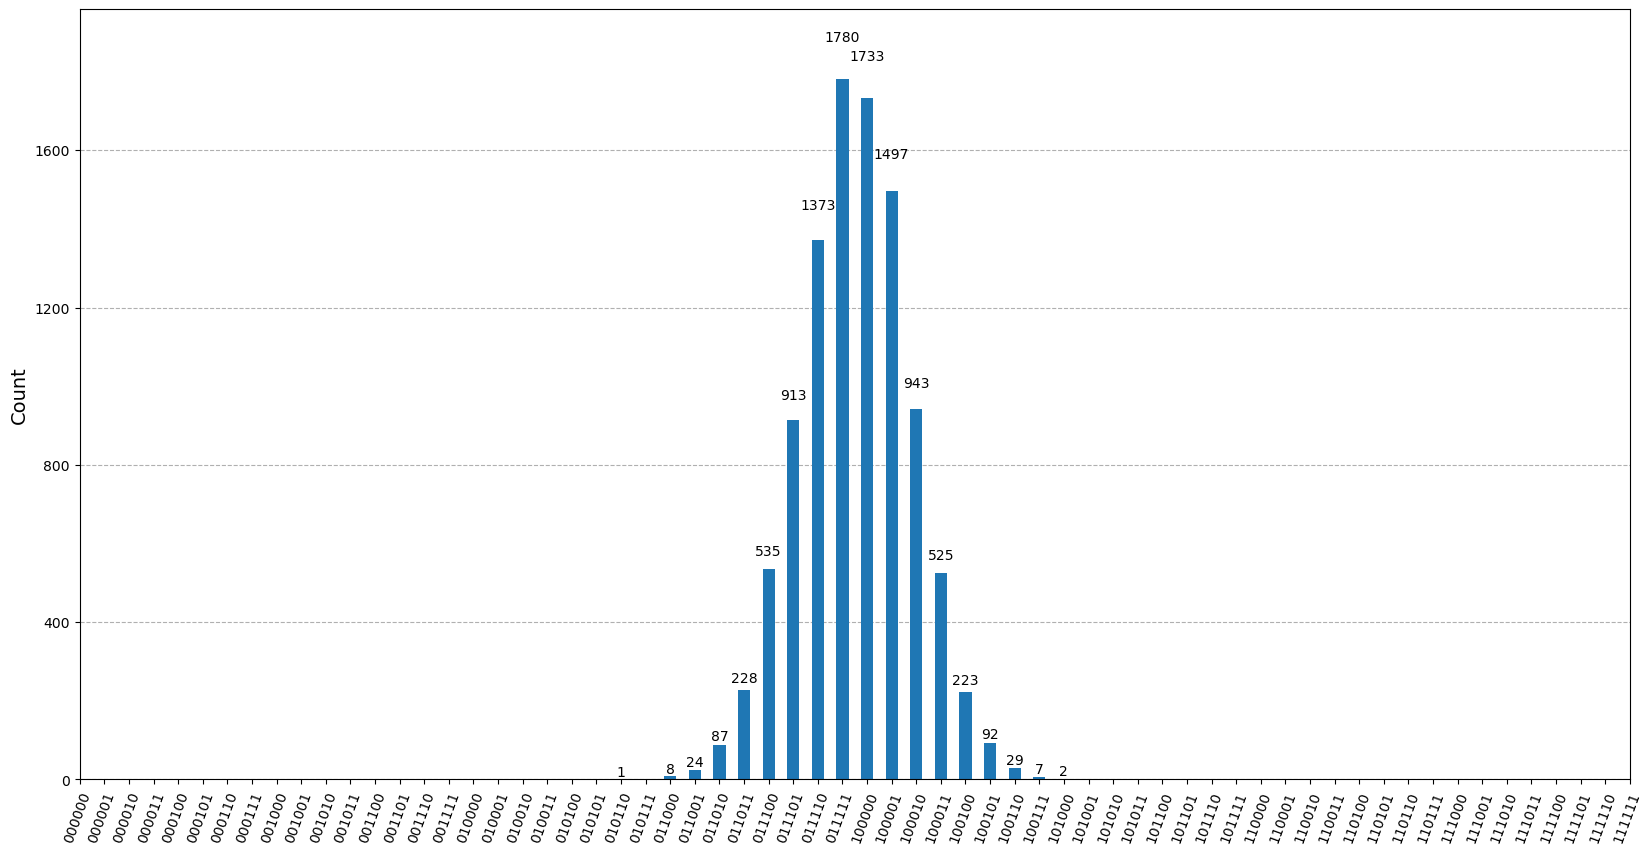

In [5]:
#Lohit Potnuru, “Simulate Quantum Particles with Python and Qiskit - Python in Plain English,” Medium, Jan. 10, 2022. https://python.plainenglish.io/simulation-of-quantum-particles-with-python-and-qiskit-cfa656bb8773.

n = 6  # number of qubits
N = 2**n  # grid points / number of states
hbar = 1 
dt = 0.1  # time step
m = 1  # mass

xMin = 0
xMax = 500
x = np.linspace(xMin, xMax, N)  #sets grid size

p = np.arange(-N/2, N/2) * ((2 * np.pi * hbar) / (N * ((xMax - xMin) / (N - 1)))) #creates momentum grid

k0 = 0   # initial momentum
x0 = xMax / 2  # initial position
sigma = (xMax - xMin) / 20  # width of wave packet
psi = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-.5 * ((x - x0) / sigma)**2) * np.exp(1j * k0 * x) #initial state

norm = np.linalg.norm(psi)
psi_normalized = psi / norm  # Normalize state

qubits = QuantumRegister(n + 1) #initializing register of qubits for the quantum circuit
splitOp = QuantumCircuit(qubits, name="splitOp") #creating the splitOp method quantum circuit
splitOp.barrier() #creates a visual barrier for the circuit

splitOp.append(QFT(n), qubits[1:]) #quantum fourier transform to each qubit

for i in range(n):
    splitOp.p(dt / 2**(n - 3 + i), n - i)

for i in range(n):
    for j in range(i + 1, n):
        splitOp.cx(n - j, 0)
        splitOp.cx(n - i, 0)
        splitOp.p(dt * (2**(2 - i - j)), 0)
        splitOp.cx(n - i, 0)
        splitOp.cx(n - j, 0)

splitOp.append(QFT(n, inverse=True), qubits[1:])  # inverse quantum fourier transform to each qubit
splitOp.barrier() #visual barrier in quantum circuit

q = QuantumRegister(n + 1) #create new quantum register with n+1 qubits
c = ClassicalRegister(n) #create six classical bits to measure onto
circuit = QuantumCircuit(q, c) #create quantum circuit with q and c registers

circuit.initialize(psi_normalized, q[1:])  # intiialize the quantum circuit with the normalized state
circuit.barrier()


iterations =  0 #number of time iterated through with each dt

for i in range(iterations):
    circuit.append(splitOp, q[:]) #split op method, appending the split op circuit for each iteration


for i in range(1, n + 1):
    circuit.measure(i, i - 1) #measure the qubits onto classical bits


simulator = AerSimulator()  # Use the AerSimulator
compiled_circuit = transpile(circuit, simulator) #compile the initialized quantum circuit with the simulator
sim_result = simulator.run(compiled_circuit, shots=10000).result() #run the simulation, doing 10000 counts


counts = sim_result.get_counts() # Get results

for a in range(N):
    s = bin(a)[2:]
    while len(s) != n:
        s = '0' + s
    if s not in counts.keys():
        counts[s] = 0   # Fill in missing states with 0

plot_histogram(counts, figsize=[20,10]) # Plot the results

#run at 0, 10, 20 iterations

In [6]:
#Real backend simulation

#Lohit Potnuru, “Simulate Quantum Particles with Python and Qiskit - Python in Plain English,” Medium, Jan. 10, 2022. https://python.plainenglish.io/simulation-of-quantum-particles-with-python-and-qiskit-cfa656bb8773.

# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="Personal Token",
    set_as_default=True,
    # Use `overwrite=True` if you're updating your token.
    overwrite=True,
)

service = QiskitRuntimeService()
backend2 = service.least_busy(simulator=False, operational=True)

n = 4  # number of qubits
N = 2**n  # grid points / number of states
hbar = 1 
dt = 0.1  # time step
m = 1  # mass

xMin = 0
xMax = 500
x = np.linspace(xMin, xMax, N)  #sets grid size

p = np.arange(-N/2, N/2) * ((2 * np.pi * hbar) / (N * ((xMax - xMin) / (N - 1)))) #creates momentum grid size

k0 = 0*m / 2  # initial momentum
x0 = xMax / 2  # initial position
sigma = (xMax - xMin) / 10  # width of wave packet
psi = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-.5 * ((x - x0) / sigma)**2) * np.exp(1j * k0 * x) #initial state

norm = np.linalg.norm(psi)
psi_normalized = psi / norm  # Normalize wavefunc

qubits = QuantumRegister(n + 1) #initializing register of qubits for the quantum circuit
splitOp = QuantumCircuit(qubits, name="splitOp") #creating the splitOp method quantum circuit
splitOp.barrier() #creates a visual barrier for the circuit


#V=0 for free particle, so no potential step term

splitOp.append(QFT(n), qubits[1:]) #quantum fourier transform to each qubit to go to momentum space

for i in range(n):
    splitOp.p(dt / 2**(n - 3 + i), n - i)   

for i in range(n):
    for j in range(i + 1, n):
        splitOp.cx(n - j, 0)
        splitOp.cx(n - i, 0)
        splitOp.p(dt * (2**(2 - i - j)), 0)
        splitOp.cx(n - i, 0)
        splitOp.cx(n - j, 0)                   #kinetic propagator

        
#free particle, V=0, so no potential step        
        
splitOp.append(QFT(n, inverse=True), qubits[1:])  # inverse quantum fourier transform to each qubit back to position basis
splitOp.barrier() #visual barrier in quantum circuit

q = QuantumRegister(n + 1) #create quantum register with n+1 qubits
c = ClassicalRegister(n) #create six classical bits to measure onto
circuit = QuantumCircuit(q, c) #create quantum circuit with q and c registers

circuit.initialize(psi_normalized, q[1:])  # intiialize the quantum circuit with the normalized state
circuit.barrier() #visual barrier


iterations =  10 #number of time iterated through with each dt

for i in range(iterations):
    circuit.append(splitOp, q[:]) #split op method, appending the circuit through each iteration


for i in range(1, n + 1):
    circuit.measure(i, i - 1) #measure the qubits onto classical bits


compiled_circuit3 = transpile(circuit, backend2) #transpile the circuit for the backend


 # running on the real backend code below
    
# job4 = backend2.run(compiled_circuit3, shots=2048, optimization_level=3) # Run the simulation on the real backend
    



counts4 = job4.result().get_counts() # Get the results


for a in range(N):
    s = bin(a)[2:]
    while len(s) != n:
        s = '0' + s
    if s not in counts3.keys():
        counts4[s] = 0   # Fill in missing states with 0


plot_histogram(counts4, figsize=[20,10]) # Plot the results


IBMNotAuthorizedError: '401 Client Error: Unauthorized for url: https://auth.quantum-computing.ibm.com/api/users/loginWithToken. Login failed., Error code: 3446.'

In [11]:
#Lohit Potnuru, “Simulate Quantum Particles with Python and Qiskit - Python in Plain English,” Medium, Jan. 10, 2022. https://python.plainenglish.io/simulation-of-quantum-particles-with-python-and-qiskit-cfa656bb8773.

# Constants
N = 500  # number of grid points
hbar = 1  # reduced Planck's constant
dt = 0.5  # time step
m = 1  # mass of particle
omega = 0.02  # angular frequency of harmonic potential

# Spatial grid
xMin = 0
xMax = 500
x = np.linspace(xMin, xMax, N)

# Momentum grid
p = np.arange(-N/2, N/2) * ((2 * np.pi * hbar) / (N * ((xMax - xMin) / (N - 1)))) 

# Initial wavefunction: Gaussian wave packet
k0 = m / 2  # initial momentum
x0 = xMax / 2  # initial position (center of the grid)
sigma = (xMax - xMin) / 30  # width of the Gaussian wavepacket
psi = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - x0) / sigma) ** 2) * np.exp(1j * k0 * x)  # initial wave packet

# Conjugate of the wavefunction (for later use)
psiC = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - x0) / sigma) ** 2) * np.exp(-1j * k0 * x) 

# Probability distribution of the wavefunction
waveP = np.conj(psi) * psi  # probability distribution of wavefunction



# Potential operator: Harmonic potential V(x) = 0.5 * m * omega^2 * (x - x0)^2
Vhat = 0.5 * m * omega**2 * (x - x0)**2

# Create potential propagator for half a time step
Vprop = np.exp(-1j * dt * Vhat / (2 * hbar))


# Kinetic energy operator: T(p) = p^2 / (2m)
That = p**2 / (2 * m)  # Kinetic energy operator in momentum space
Tprop = np.exp(-1j * dt * That / hbar)  # Kinetic propagator for full time step

# Function for one step of the split operator method
def splitOperator(psi, Vprop=Vprop, Tprop=Tprop):
    psi *= Vprop  # Apply half-step potential propagator
    psi_p = np.fft.fft(psi)  # Transform to momentum space
    psi_p *= Tprop  # Apply full-step kinetic propagator
    psi = np.fft.ifft(psi_p)  # Transform back to spatial space
    psi *= Vprop  # Apply half-step potential propagator
    return psi

# Animation setup
fig, ax = plt.subplots()
plt.close()

ax.set_xlim((0, 500))
ax.set_ylim((-0.0005, 0.0025))
line, = ax.plot([], [], lw=2)
lineV, = ax.plot([], [], lw=2)

# Initialize animation
def init():
    line.set_data([], [])
    lineV.set_data([], [])
    return (line, lineV,)

# Producing the animation
def animate(i):
    global psi
    psi = splitOperator(psi)  # Update wavefunction with the split-operator method
    line.set_data(x, np.abs(psi)**2)  # Plot the probability density |psi|^2
    lineV.set_data(x, Vhat / np.max(Vhat) * 0.001)  # Scale potential for visualization
    return (line, lineV,)

# Run animation with set number of frames
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=500, interval=10, blit=True)

# Display the animation
rc('animation', html='jshtml')
anim
